In [1]:
# reloads modules when running again
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from model_functions import *

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import pairwise_distances

import warnings
warnings.filterwarnings('ignore')

## Data loading

In [3]:
data, metadata = load_data()

### Constants

In [4]:
test_size = 10

## Data preprocessing

### Split to train-test

In [5]:
# sort data by collection date
data = data.sort_values(by="collection_date")

# split to train & test by test_size last samples
test_df = data.groupby('baboon_id').tail(test_size)
train_df = data.drop(test_df.index)
test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# can be uncomment and used for extrapulation
# train_df = data.groupby('baboon_id').head(4)
# test_df = data.drop(train_df.index)
# test_df = test_df.reset_index(drop=True)
# train_df = train_df.reset_index(drop=True)

In [6]:
meta_features_union = meta_features + ["month_sin", "month_cos"]
x_test, y_test = test_df[meta_features_union], test_df.drop(columns=meta_features_union)
x_test["interpolated"] = 0

### Aggregation

In [7]:
# aggregate to one sample per week
train_df = aggregate_samples(train_df.copy())

### Interpolation hyperparameter tuning

In [8]:
# np.random.seed(42)
# hole_indices = np.random.randint(0,len(train_df), 160)
# holes = train_df.iloc[hole_indices, :]
# original_df = train_df.drop(holes.index)

# interpolated_holes = pd.DataFrame()
# for index, hole in holes.iterrows():
#     hole = hole[meta_features_union]
#     interpolated_holes = pd.concat([interpolated_holes, single_knn_interpolation(original_df, hole, 5, interpolation_dist_metric, filter_dates=True)], axis=1)
# interpolated_holes = interpolated_holes.T.reset_index(drop=True)

In [9]:
# d_matrix = pairwise_distances(interpolated_holes[y_test.columns], holes[y_test.columns], metric="braycurtis").diagonal()
# pd.DataFrame(d_matrix).to_csv("braycurtis_performance_interpolation.csv")
# braycurtis_score = d_matrix.mean()
# braycurtis_score

### Interpolation

In [10]:
interpolated_df = train_df.copy()

In [11]:
# interpolated_df = knn_interpolation(train_df)
# interpolated_df.to_csv("interpolated_df.csv")

In [12]:
# can be uncomment for loading the data from a csv file instead of running the knn_interpolation function

# interpolated_df = pd.read_csv("interpolated_df.csv")

In [13]:
interpolated_df["collection_date"] = pd.to_datetime(interpolated_df["collection_date"])
taxa_columns = [col for col in interpolated_df.columns if col not in meta_features_union + ["interpolated"]]

## Train

In [14]:
# can be uncomment and used to run only the trend model

# pred_df = trend_pred(interpolated_df, x_test)
# pred_df.to_csv("trend_df.csv")

In [15]:
# can be uncomment and used to run only the seasonal model

pred_df = seasonal_pred(interpolated_df, x_test)
pred_df.to_csv("seasonal_df.csv")

finished 10 out of 800
finished 20 out of 800
finished 30 out of 800
finished 40 out of 800
finished 50 out of 800
finished 60 out of 800
finished 70 out of 800
finished 80 out of 800
finished 90 out of 800
finished 100 out of 800
finished 110 out of 800
finished 120 out of 800
finished 130 out of 800
finished 140 out of 800
finished 150 out of 800
finished 160 out of 800
finished 170 out of 800
finished 180 out of 800
finished 190 out of 800
finished 200 out of 800
finished 210 out of 800
finished 220 out of 800
finished 230 out of 800
finished 240 out of 800
finished 250 out of 800
finished 260 out of 800
finished 270 out of 800
finished 280 out of 800
finished 290 out of 800
finished 300 out of 800
finished 310 out of 800
finished 320 out of 800
finished 330 out of 800
finished 340 out of 800
finished 350 out of 800
finished 360 out of 800
finished 370 out of 800
finished 380 out of 800
finished 390 out of 800
finished 400 out of 800
finished 410 out of 800
finished 420 out of 800
f

In [16]:
# pred_df = predict(interpolated_df, x_test)
# pred_df.to_csv("pred_df.csv")

## Performance analysis

In [17]:
# can be uncomment for loading the data from a csv file instead of running the predict function

# pred_df = pd.read_csv("pred_df.csv")

In [18]:
# calculating Bray-Curtis score
d_matrix = pairwise_distances(pred_df[y_test.columns], y_test, metric="braycurtis").diagonal()
pd.DataFrame(d_matrix).to_csv("braycurtis_performance.csv")
braycurtis_score = d_matrix.mean()

### Performance Analysis

In [19]:
print(f"Bray-Curtis score: {round(braycurtis_score, 5)}")

Bray-Curtis score: 0.39085


In [20]:
analysis_df = x_test.copy()
analysis_df["braycurtis_score"] = d_matrix
analysis_df.drop(columns=["interpolated", "month_sin", "month_cos"], inplace=True)

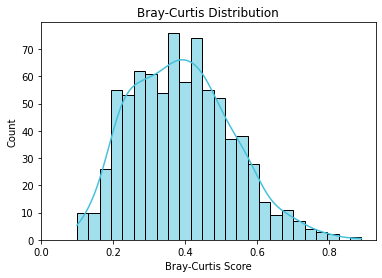

In [21]:
# Bray-Curtis Distribution
plt.grid(False)
sns.histplot(analysis_df["braycurtis_score"], color="#46c1db", bins=25, kde=True)
plt.title("Bray-Curtis Distribution")
plt.xlabel("Bray-Curtis Score")
plt.xlim(0)
plt.show()

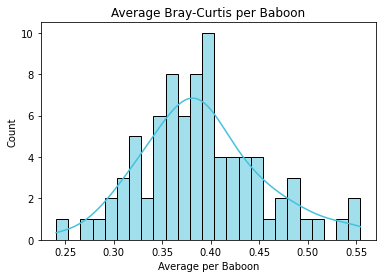

In [22]:
# Bray-Curtis Distribution
plt.grid(False)
sns.histplot(analysis_df.groupby("baboon_id")[["braycurtis_score"]].agg("mean")["braycurtis_score"], color="#46c1db", bins=25, kde=True)
plt.title("Average Bray-Curtis per Baboon")
plt.xlabel("Average per Baboon")
plt.show()

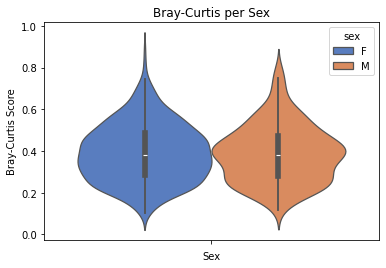

In [23]:
# Bray-Curtis by sex
plt.grid(False)
sns.violinplot(data=analysis_df, hue="sex", y="braycurtis_score", palette="muted")
plt.title("Bray-Curtis per Sex")
plt.xlabel("Sex")
plt.ylabel("Bray-Curtis Score")
plt.show()

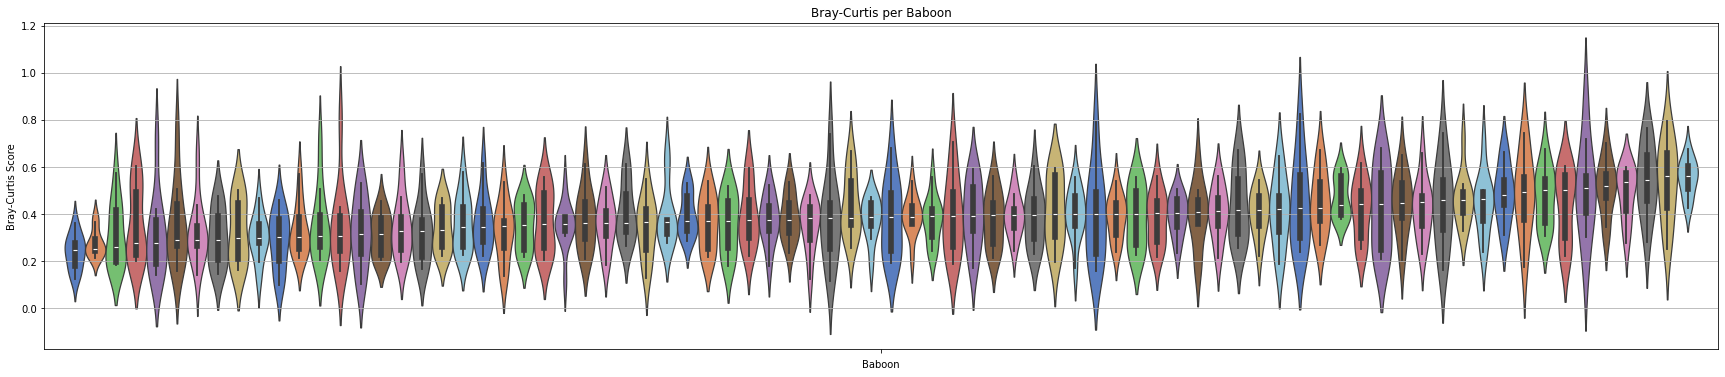

In [24]:
# Bray-Curtis per Baboon
plt.figure(figsize=(30, 6))
plt.grid(True)
analysis_df["baboon_mean"] = analysis_df.groupby("baboon_id")[["braycurtis_score"]].transform("median")["braycurtis_score"]
sns.violinplot(data=analysis_df.sort_values("baboon_mean"), hue="baboon_id", y="braycurtis_score", palette="muted", legend=False)
plt.title("Bray-Curtis per Baboon")
plt.xlabel("Baboon")
plt.xlim((-0.41,0.41))
plt.ylabel("Bray-Curtis Score")
plt.show()

In [25]:
# creating a dictionary of babbon_id:last known sample
d = dict()
for baboon_id in train_df["baboon_id"].unique():
    d[baboon_id] = [sorted(train_df[train_df["baboon_id"] == baboon_id]["collection_date"].to_list())[-1]]
df1 = pd.DataFrame(d).T
merged_df = analysis_df.merge(df1, left_on="baboon_id", right_index=True)

In [26]:
# computing the distance between each sample to the last one in the train dataset
merged_df.rename(columns={0:"last_timepoint"}, inplace=True)
merged_df["dist_in_days"] = 0
merged_df["dist_in_days"] = merged_df.apply(lambda row: np.abs(row["collection_date"] - row["last_timepoint"]).total_seconds() / (60 * 60 * 24), axis=1)

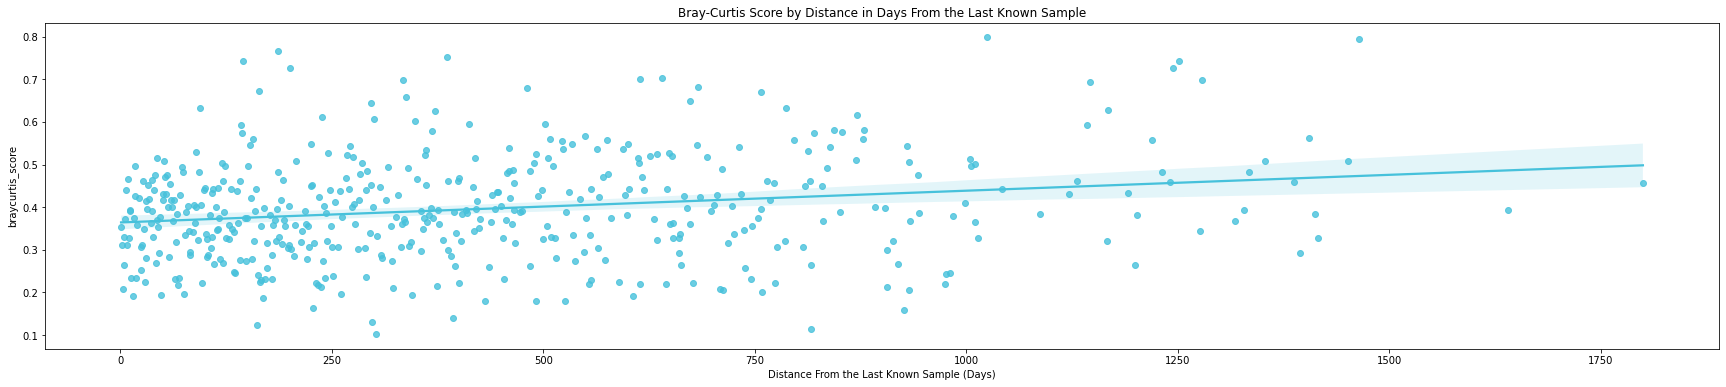

In [27]:
# plot the Bray-Curtis score for the distances in days
mean_by_dist = merged_df.groupby("dist_in_days")[["braycurtis_score"]].mean()
plt.figure(figsize=(30, 6))
sns.regplot(x=mean_by_dist.index, y=mean_by_dist["braycurtis_score"], color="#46c1db")
plt.xlabel("Distance From the Last Known Sample (Days)")
plt.title("Bray-Curtis Score by Distance in Days From the Last Known Sample")
plt.show()

### Milestone 3 Plots - Parameter Tuning

In [28]:
def plot_fig(df, line, log=False):
    plt.figure(figsize=(8, 6))
    plt.plot(df["weight"], df["avg_bray_curtis"])
    if (log):
        plt.xscale("log")
    plt.axvline(x = line, color  = 'black', linestyle = '--') 
    plt.xticks(df["weight"], df["weight"], rotation=30)
    plt.ylabel("Bray-Curtis Score")
    plt.xlabel("Weight")
    plt.show()

In [29]:
time_param_df = pd.read_csv("time_weight_interpolation.csv").sort_values(by="weight")
baboon_param_df = pd.read_csv("baboon_weight_interpolation.csv").sort_values(by="weight")
social_param_df = pd.read_csv("social_weight_interpolation.csv").sort_values(by="weight")

FileNotFoundError: [Errno 2] No such file or directory: 'time_weight_interpolation.csv'

In [ ]:
plot_fig(time_param_df, line =  0.01, log=True)
plot_fig(baboon_param_df, line = 0.2)
plot_fig(social_param_df, line = 0.6)